## Disentangling Manifolds for Continuous Factors

## Spiral Manifold

In this case study the advanced case of a spiral manifold is solved by the flow model under consideration. Similar to the other case studies, this one can be solved by a three stage model. As can be seen from the stage-wise decomposition, the majority of the disentanglement is completed at the end of the second stage and therafter the point-cloud is rescaled. The cross-validation analysis shows that the model reliably solves the task across the five partitions of the data.

In [ ]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl
from gyoza.modelling import flow_layers as mfl, masks as gmm
from gyoza.tutorials import data_iterators as mdis, data_synthesis as gtd, plotting as gtp, mathematics as gtm, standard_layers as msl

from ipywidgets import interact, fixed
tf.keras.backend.set_floatx('float64')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

### Data Synthesis

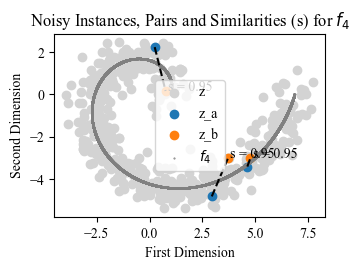

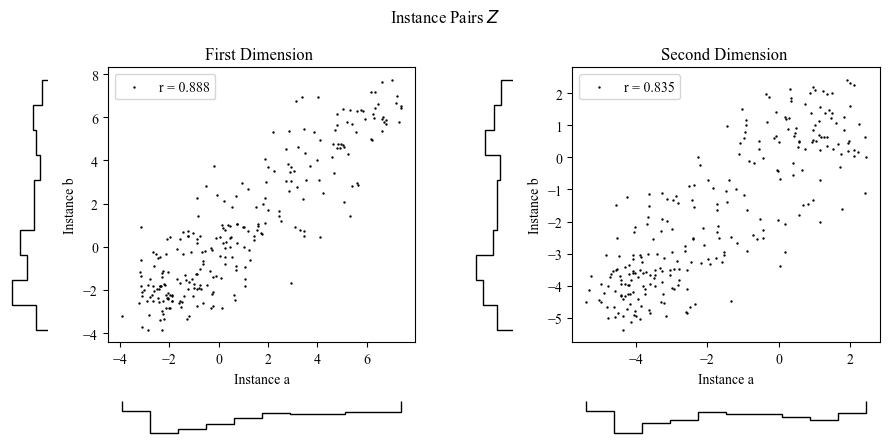

In [2]:
# Set up the raw manifold function
M = 2**14; N = 2
manifold_name = 'f_4'
manifold_function = lambda S: gtm.logarithmic_spiral(xs=np.log((S+s_max)/(1*np.sqrt(1+beta**2)/beta)+1)/beta, alpha=1, beta=beta) # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t

# Generate a dataset
golden_ratio = (1 + 5 ** 0.5) / 2
beta = np.log(golden_ratio)/(np.pi/2) # https://en.wikipedia.org/wiki/Golden_spiral see section on mathematics
s_max = (1*np.sqrt(1+beta**2)/beta)*(np.exp(beta*2*np.pi)-1)/2 # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t the arc length of the golden spiral for one full rotation
S = np.linspace(-s_max,s_max,M, dtype=tf.keras.backend.floatx()) # These points are the steps along any manifold

gtd.reset_random_number_generators(seed=653) # Reproducability
noise_standard_deviation = [0.5, 0.5]
Z, Y = gtd.create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

batch_size = 2**8
target_correlations = [0.0, 0.95]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Plot pairs of instances
Z_ab, Y_ab  = next(iterator)
gtp.plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)
gtp.plot_instance_pairs_2(Z_ab=Z_ab)

### Model Creation

In [3]:

def create_network(stage_count: int, random_seed: int = 0, sigma: float = 0.95) -> mfl.SupervisedFactorModel:
    """This function creates a supervised factor network that has starts with an activation normalization layer and then has ``stage_count`` many
    consecutive processing stages. Each stage consists of a reflection layer, followed by an full coupling layer (two additive coupling layers, each
    followed by a Heaviside permutation, one with nagative) and an activation normalization layer. During inference, the network takes input :math:`Z`
    and outputs :math:'\tilde{Z}' which each have shape [:math:`M`, :math:`N`], where :math:`M` is the instance count and :math:`N=2` is the
    dimensionality.

    :param stage_count: The number of processing stages that the ``network`` shall use.
    :type stage_count: int
    :param random_seed: The seed used to reset the random number generators.
    :type random_seed: int, optional, defaults to 0
    :param sigma: The association strength of maximally similar data points. It should be in the range (0,1].
    :type sigma: float, default = 1
    :return: network (:class:`SupervisedFactorModel`) - The network.
    """
    gtd.reset_random_number_generators(seed=random_seed) # Reproducability
    
    # Set up the coupling functions and masks for the coupling layers
    layers = [None] * (6*stage_count+1)
    layers[0] = mfl.ActivationNormalization(axes=[1], shape=[N])
    for i in range(stage_count):
        layers[6*i+1] = mfl.Reflection(axes=[1], shape=[N], reflection_count=1)

        compute_coupling_parameters_1 = msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3)
        mask_1 = gmm.CheckerBoard(axes=[1], shape=[N])

        layers[6*i+2] = mfl.AdditiveCoupling(axes=[1], shape=[N], compute_coupling_parameters=compute_coupling_parameters_1, mask=mask_1)
        layers[6*i+3] = mfl.Heaviside(axes=[1], shape=[N])

        compute_coupling_parameters_2 = msl.BasicFullyConnectedNet(latent_dimension_count=4*N, output_dimension_count=N, depth=3)
        mask_2 = gmm.CheckerBoard(axes=[1], shape=[N])

        layers[6*i+4] = mfl.AdditiveCoupling(axes=[1], shape=[N], compute_coupling_parameters=compute_coupling_parameters_2, mask=mask_2)
        layers[6*i+5] = mfl.Heaviside(axes=[1], shape=[N])

        layers[6*i+6] = mfl.ActivationNormalization(axes=[1], shape=[N])

    # Construct the network
    network = mfl.SupervisedFactorModel(layers, dimensions_per_factor=[1,1], sigma=sigma) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)
    
    # Outputs
    return network
 

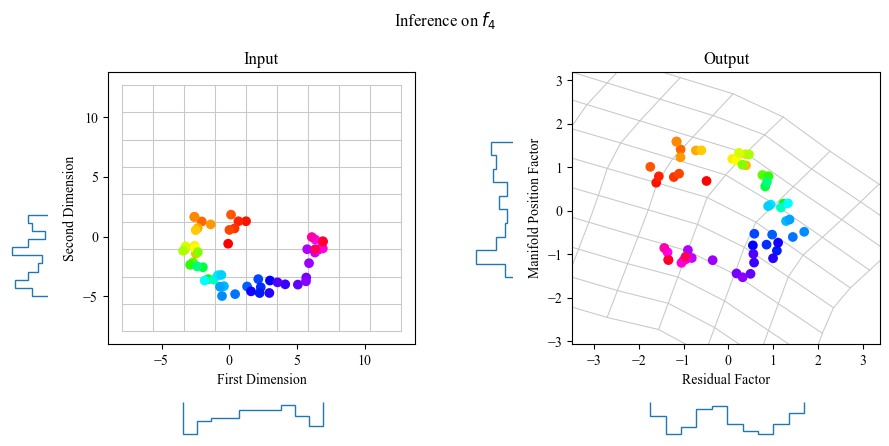

In [4]:
# Create network
gtd.reset_random_number_generators(seed=2) # Reproducability
network = create_network(stage_count=3)

# Plot input and output
gtp.plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name, zoom_output=True)

### Model Training

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - Train Loss: 4.2063


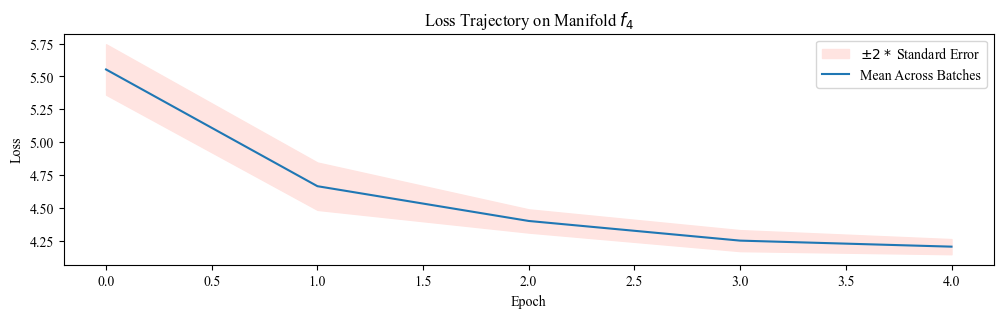

In [5]:
# Calibrate network
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
batch_size = 1024
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=5, batch_count=M//batch_size)
gtp.plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=346) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_model(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=800, epoch_count=200, similarity_function=similarity_function, manifold_name=manifold_name)

### Evaluation

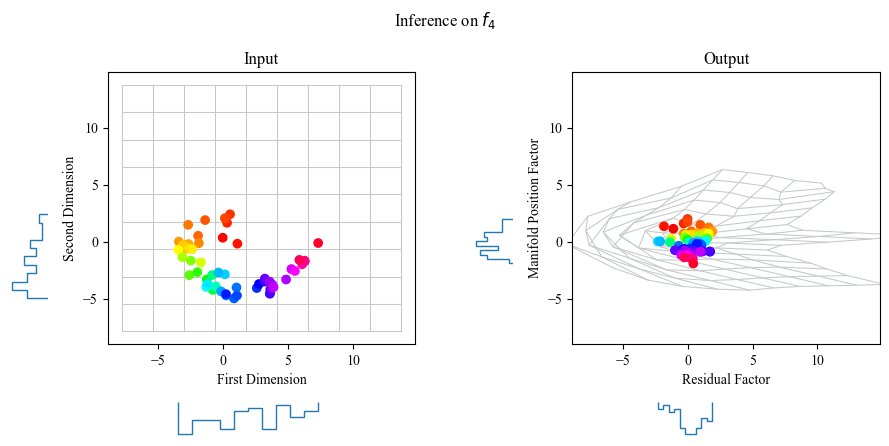

In [6]:
# Plot input and output
gtp.plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


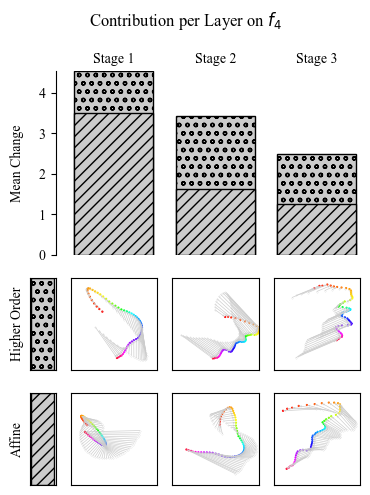

In [7]:
# Plot stage-wise contribution
gtp.plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21], step_titles=['Stage 1','Stage 2','Stage 3'])

In [8]:
# Plot interactive tool
interact(gtp.plot_inverse_point, position=(-2.0,2.0,0.1), residual=(-1.5,1.5,0.1), S=fixed(np.random.choice(a=S, size=[128], replace=False)), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

interactive(children=(FloatSlider(value=0.0, description='position', max=2.0, min=-2.0), FloatSlider(value=0.0…

<function gyoza.tutorials.plotting.plot_inverse_point(position: float, residual: float, S: numpy.ndarray, network: gyoza.modelling.flow_layers.SupervisedFactorModel, manifold_function: Callable, manifold_name: str)>

In [ ]:
# Plot cross validation
gtp.evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name)

## Circle Manifold

In this case study the model is calibrated to straighten a circular manifold. This task is difficult because at the junction point of the circle (point (1,0)) there exist adjacent points that are supervised to be maximally distant. As can be seen from the layer-wise analysis, the circle is split already at the non-linear component of the first stage. Since the coupling layer is the only one capable of non-linear transformations it shows the importance of that layer. The position factor is disentangled from the residual factor by the end of the second layer and the third layer ensures proper scaling. The loss trajectory of this model remains spiky throughout the calibration. Furthermore, the cross-validation analysis shows that not all versions of the model manage to create a linear relationship between predicted and actual position. These observations hint at the complexity of this task.

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_5'
manifold_function = lambda S: (np.cos(S), np.sin(S))#((2*s_max/(2*np.pi))*np.cos((S+s_max)*(2*np.pi)/(2*s_max)), (2*s_max/(2*np.pi))* np.sin((S+s_max)*(2*np.pi)/(2*s_max)))

M = 2**13; N = 2 # Instance count, dimension count
reset_random_number_generators(seed=3) # Reproducability
S = np.random.uniform(low=0, high=2*np.pi, size=[M])#np.random.normal(loc=0, scale=1, size=[M])

# Generate a dataset
reset_random_number_generators(seed=123) # Reproducability
noise_standard_deviation = [0.1, 0.1]
Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
batch_size = M//8
target_correlations = [0.0, 0.95]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, target_correlations=target_correlations)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab[:3,:,:], Y_ab=Y_ab[:3,:], manifold_function=manifold_function, manifold_name=manifold_name)

In [ ]:
# Create network
reset_random_number_generators(seed=52) # Reproducability
network = create_network(stage_count=3)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);


In [ ]:
# Calibrate network
batch_size = M//8
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=100, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

In [ ]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

### Evaluation

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=958) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_network(Z_sample=Z[np.random.choice(M, size=128)], stage_count=3)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=800, epoch_count=1000, similarity_function=similarity_function, manifold_name=manifold_name)

In [ ]:
# Plot input and output
plot_input_output(network, S_range = [np.min(S), np.max(S)], manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21], step_titles=['Stage 1','Stage 2','Stage 3'])

In [ ]:
# Plot interactive tool
interact(plot_inverse_point, position=(-1.2,1.2,0.1), residual=(-1.5,1.5,0.1), S=fixed(np.random.choice(a=S, size=[batch_size], replace=False)), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name))

In [ ]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name)

## Flip Flop Manifold

In this case study the manifold takes the shape of two intermingling flaps. The position along the manifold is either on the left flap or on the right flap (thus no distinction for position along a flap). It therefore combines the discontinuity, curvature and category properties of earlier case studies. The model does converge throughout calibration. As can be seen from the scatterplots, the disentanglement aligns the left flap with the top halfplane and the right flap with the bottom half plane. Although not explicitly supervised to do so, it preserves proximities of data points. This is likely due to the fact that the data points were arranged along the flap in the input space and permuting them would require a more complicated mapping than necessary. The first three stages of the model are mostly responsible for the non-linear transformations while the last two stages are responsible for rotation and scaling, indicating that a smaller model might also work. Lastly, the cross-validation results show that different initializations of the model all lead to a reliable separation of the flaps.

### Data Synthesis

In [ ]:
# Set up the raw manifold function
manifold_name = 'f_8'
def manifold_function(S):
    s_max = np.max(S)
    tmp = np.zeros([len(S),2])
    tmp[S<0,0] = S[S<0] + s_max/6
    tmp[0<=S,0] = S[0<=S] - s_max/6
    tmp[S<0,1] = tmp[S<0,0] **2/10 -4
    tmp[0<=S,1] = -tmp[0<=S,0] ** 2/10 + 4

    return (tmp[:,0], tmp[:,1])

# Generate a dataset
reset_random_number_generators(seed=395) # Reproducability
noise_standard_deviation = [0.2, 0.2]

M = 2**13; N = 2 # Instance count, dimension count
S = np.random.normal(loc=0.0, scale=1.0, size=[M])#np.random.normal(loc=0, scale=1, size=[M])

Z, Y = create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, F]

# Plot pairs of instances
target_correlations = [0, 0.8]
batch_size = M//8
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size=batch_size, target_correlations=target_correlations)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)

### Model Training

In [ ]:
# Create network
reset_random_number_generators(seed=294) # Reproducability
network = create_network(stage_count=5, sigma = 1.0)
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:

# Calibrate network
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=10, batch_count=M//batch_size)
plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

### Model Evaluation

In [ ]:
# Plot input and output
plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name);

In [ ]:
# Cross validate model behaviour
reset_random_number_generators(seed=958) # Reproducability
networks = [None] * 5 # Fold-count many networks
for i in range(len(networks)):
    networks[i] = create_model(Z_sample=Z[np.random.choice(M, size=128)], stage_count=5, sigma = 0.8)
    networks[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
Z_test, Y_test = cross_validate(Z=Z, Y=Y, networks=networks, batch_size=512, epoch_count=50, similarity_function=similarity_function_8, manifold_name=manifold_name)

In [ ]:
# Plot stage-wise contribution
plot_contribution_per_layer(network=network, s_range=(np.min(S), np.max(S)), manifold_function=manifold_function, manifold_name=manifold_name, layer_steps=[7,14,21,28,35], step_titles=['Stage 1','Stage 2','Stage 3','Stage 4','Stage 5'])

In [ ]:
# Plot interactive tool
interact(plot_inverse_point, position=(-2,2,0.1), residual=(-2,2,0.1), S=fixed(S_sample), network=fixed(network), manifold_function=fixed(manifold_function), manifold_name=fixed(manifold_name));

In [ ]:
# Plot cross validation
evaluate_and_plot_networks(Z_test=Z_test, Y_test=Y_test, networks=networks, manifold_name=manifold_name);